In this notebook we explore how to develop and tune an effective model for text classification. In the end, there's a function that uses cross-validation to find the best model & hyperparameters (if applicable). 

### To-Do Improvements:
* Add more models to tests (e.g. LDA, QDA)
* Include the option to test more hyperparameters in the cross-val tests
* Include the option to maximize a different parameter than accuracy, which is only useful when the classes are balanced

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
import numpy as np
import seaborn as sns

# Exploring the Data

In [4]:
# Example Data
# With this teeny tiny example data set, we aim to classify Sports article headlines into the relevant sport
data = [
    ['NFL', 'Lighter Ezekiel Elliott is carrying Cowboys on his shoulders'],
    ['NFL', 'Giants sticking with Eli Manning, but won’t rule out Alex Tanney or Kyle Lauletta'],
    ['NFL', 'Jaguars will put Andrew Norwell on injured reserve'],
    ['NFL', 'Jaguars fire offensive coordinator Nathaniel Hackett'],
    ['NFL', 'Ryan Tannehill will start for Dolphins on Sunday'],
    ['NFL', 'Giants encourage Ballentine to skip minicamp'],
    ['NFL', "Source: Raiders' Crowell hurt, done for season"],
    ['NFL', "Steelers' mistakes lead to Broncos' surprising win"],
    ['NFL', 'Panthers stumbling after crushing loss to Seahawks'],
    ['NFL', 'Raiders signing tight end off Ravens practice squad'],
    ['NFL', '2019 NFL draft: Fantasy football reaction'],
    ['NFL', '2019 NFL draft: Biggest post-draft questions for all 32 teams'],
    ['NFL', 'Chiefs hopeful Eric Berry can return to practice next week'],
    ['NFL', 'Malcolm Jenkins: We lacked fight in New Orleans'],
    ['NFL', 'AFC playoff picture: Chiefs stay on top of a wide-open race'],
    ['NFL', "PFT's Week 12 superlatives"],
    ['NFL', 'Packers left tackle David Bakhtiari suffers two knee injuries'],
    ['NFL', 'Aaron Rodgers knows the Packers need to win out and get help'],
    ['NFL', 'Should Ravens stick with Jackson as starter?'],
    ['NFL', 'FMIA Week 11—Embedded in New Orleans: The Ritz, the Rout and the Reason the Saints Are Unstoppable'],
    ['NFL', 'Passing stats are up around the NFL, but Tom Brady’s are down'],
    ['NFL', 'FMIA Week 10: Rams Manage Win After Fire-Filled Week of ‘Horror’'],
    ['NFL', "Cowboys to sign Hall of Famer Larry Allen's son"],
    ['NFL', 'Giants vs. Athletics, Jul. 31'],
    ['NFL', "Ravens shouldn't be indecisive on Kaepernick"],
    ['Soccer', 'U.S. U-20 MNT sets up rematch with Mexico in CONCACAF U-20 Championship'],
    ['Soccer', 'LIVE: USMNT vs. Italy – Pulisic wearing captain’s armband'],
    ['Soccer', 'Report: Chelsea to double Kante’s wages'],
    ['Soccer', 'UEFA to introduce VAR in Champions League knockout stage'],
    ['Soccer', 'UEFA: FFP rules must be “strong and clear”'],
    ['Soccer', 'Tottenham throttle Chelsea in impressive fashion'],
    ['Soccer', 'Extended Highlights: Tottenham roll past Chelsea'],
    ['Soccer', 'Premier League clubs ranked by highest average salaries'],
    ['Soccer', 'FOLLOW LIVE: MLS Conference Finals 1st Legs'],
    ['Soccer', 'Sources: Barca to copy City against Liverpool'],
    ['Soccer', "Weekend review: Liverpool and City won't blink"],
    ['Soccer', 'Messi, Dembele combine to give Barca late equalizer at Atleti'],
    ['Soccer', 'Bundesliga wrap: Bayern falls, Eintracht rises, USMNT’s Wright debuts'],
    ['Soccer', 'Arsenal v. Leicester City'],
    ['Soccer', 'De Gea 4/10 as his howler costs Man United victory'],
    ['Soccer', 'UCL takeaways: Liverpool problems extended beyond Messi'],
    ['Soccer', "Source: Chelsea not for sale to UK's richest man"],
    ['Soccer', 'Ramsey has played last Arsenal match - Emery'],
    ['Soccer', "Sarri worried as Chelsea's defence faces crisis"],
    ['Soccer', "Relive Arsenal's season opening win with fans"],
    ['NBA', "Three Things to Know: Kevin Durant goes off for 51 but Kawhi Leonard, Raptors get win"],
    ['NBA', "Kevin Durant gave his jersey to Drake on the court postgame"],
    ['NBA', "Report: Some Cavaliers players upset about Kyle Korver trade"],
    ['NBA', "PBT Extra: Utah gets a little help with Kyle Korver trade"],
    ['NBA', "Lillard: Blazers' jawing at refs reveals distraction"],
    ['NBA', "Rockets, Warriors both hope for cleaner Game 2"],
    ['NBA', "NBA playoff winners and losers: Russ, Dame and the Warriors"],
    ['NBA', "McCollum leads Blazers past cold Nuggets, 97-90"],
    ['NBA', "Blazers seeking better balance against Nuggets"],
    ['NBA', "Korver won't solve all of Utah's problems"],
    ['NBA', "Report: Cavaliers willing to take on long-term salary in trades"],
    ['NBA', "Durant outplaying Harden when it matters most"],
    ['NBA', "KD: Harden's style 'clever,' not cheating at all"],
    ['NBA', "Sources: Popovich expected to sign 3-year deal"],
    ['NBA', "Cavaliers trade Kyle Korver to Jazz for Alec Burks, second-rounders"],
    ['NBA', "Durant leads the way again, Warriors lead Rockets 2-0"]
]

df = pd.DataFrame(data=data, columns=['Category', 'Title'])
df

,Category,Title
0,NFL,Lighter Ezekiel Elliott is carrying Cowboys on...
1,NFL,"Giants sticking with Eli Manning, but won’t ru..."
2,NFL,Jaguars will put Andrew Norwell on injured res...
3,NFL,Jaguars fire offensive coordinator Nathaniel H...
4,NFL,Ryan Tannehill will start for Dolphins on Sunday
5,NFL,Giants encourage Ballentine to skip minicamp
6,NFL,"Source: Raiders' Crowell hurt, done for season"
7,NFL,Steelers' mistakes lead to Broncos' surprising...
8,NFL,Panthers stumbling after crushing loss to Seah...
9,NFL,Raiders signing tight end off Ravens practice ...


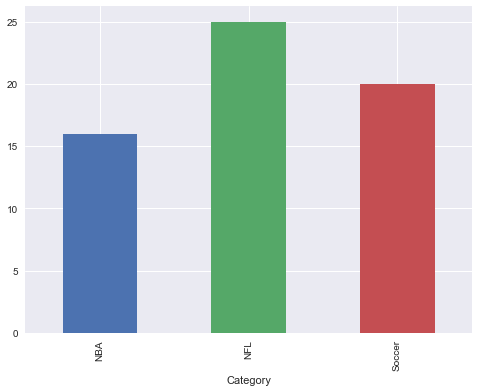

In [5]:
sns.set()
fig = plt.figure(figsize=(8, 6))
df.groupby('Category').Title.count().plot.bar(ylim=0)
plt.show()

# Feature Extraction

## tf-idf

We'll use Term Frequency Inverse Document Frequency (tf-idf) to extract features from the text. tf-idf reflects how important a word is to a document in a collection. 

### Term Frequency

Term frequency $tf(t,d)$ can be simply the raw count of a term in a document. Let's denote the raw count by $f_{t,d}$. You can also calculate term frequency by adjusing for document length

$tf(t,d) = \frac{f_{t,d}}{Number of Words in D}$

### Inverse Document Frequency
Inverse document frequency measures how much information the word provides, i.e. if it's common or rare across all the documents

$idf(t,D) = log \frac{N}{|{d \in D: t\in d}|}$

$N$ is the total number of documents in the corpus
$|{d \in D: t \in d}|$ is the number of documents where the term $t$ appears

### Term Frequency - Inverse Document Frequency

$tfidf(t,d, D) = tf(t, d) \cdot idf(t, D)$

## Parameters in CountVectorizer

* **min_df**: Minimum number of documents a word must be present in to be kept
* **lowercase**: Convert all characters to lowercase before tokenizing
* **stop_words**: Common words that we can ignore when tokenizing
* **norm**: Set to l2 to ensure all feature vectors have a euclidean norm of 1
* **ngram_range**: Set to (1, 2) to indicate considering both unigrams and bigrams

In [6]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, ENGLISH_STOP_WORDS

# Custom Stop Words
print(ENGLISH_STOP_WORDS)  # here's the default English stop words

frozenset({'if', 'nowhere', 'none', 'yours', 'this', 'becoming', 'hereby', 'empty', 'show', 'why', 'third', 'who', 'himself', 'system', 'than', 'out', 'although', 'hundred', 'noone', 'move', 'last', 'their', 'yourselves', 'whoever', 'becomes', 'hereupon', 'on', 'very', 'give', 'the', 'amount', 'part', 'whereby', 'until', 'while', 'my', 'thin', 'each', 'thereupon', 'sincere', 'toward', 'everyone', 'has', 'something', 'even', 'whom', 'other', 'yet', 'beyond', 'could', 'inc', 'that', 'with', 'whatever', 'mine', 'afterwards', 'else', 'any', 'call', 'within', 'more', 'beside', 'full', 'always', 'thereby', 'five', 'a', 'since', 'forty', 'someone', 'amongst', 'latter', 'cannot', 'nobody', 'off', 'over', 'per', 'seem', 'do', 'therefore', 'not', 'without', 'herself', 'itself', 'now', 'anything', 'through', 'us', 'either', 'to', 'he', 'into', 'whole', 'during', 'nothing', 'up', 'became', 'then', 'anyone', 'rather', 'found', 'her', 'however', 'together', 'being', 'due', 'meanwhile', 'nevertheless

In [7]:
# Demonstrating how you would add custom stop words
custom_stop_words = {
    'v',
    'vs',
}
stop_words = ENGLISH_STOP_WORDS.union(custom_stop_words)

In [9]:
# Let's split our data set into a training set and a test set
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df.Title, df.Category, test_size=0.20, random_state=0)

In [10]:
# CountVectorizer converts a collection of text documents into a matrix of word counts
# where each row represents a document, and the columns are each word feature (unigrams and bigrams)
count_vect = CountVectorizer(
    stop_words=stop_words, ngram_range=(1, 2), min_df=1)
X_train_counts = count_vect.fit_transform(X_train)
X_train_counts.shape

(48, 504)

In [11]:
print(X_train_counts[3])

  (0, 368)	1
  (0, 357)	1
  (0, 200)	1
  (0, 48)	1
  (0, 249)	1
  (0, 109)	1
  (0, 367)	1
  (0, 356)	1
  (0, 199)	1
  (0, 47)	1
  (0, 248)	1


In [12]:
# TfidfTransformer transforms a count matrix to a normalized tf-idf representation
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
print(X_train_tfidf[3])

  (0, 248)	0.30575065111394517
  (0, 47)	0.2552751328155287
  (0, 199)	0.30575065111394517
  (0, 356)	0.30575065111394517
  (0, 367)	0.30575065111394517
  (0, 109)	0.30575065111394517
  (0, 249)	0.30575065111394517
  (0, 48)	0.30575065111394517
  (0, 200)	0.30575065111394517
  (0, 357)	0.30575065111394517
  (0, 368)	0.30575065111394517


In [13]:
count_vect.vocabulary_

{'source': 416,
 'chelsea': 63,
 'sale': 394,
 'uk': 462,
 'richest': 369,
 'man': 262,
 'source chelsea': 417,
 'chelsea sale': 66,
 'sale uk': 395,
 'uk richest': 463,
 'richest man': 370,
 'follow': 158,
 'live': 252,
 'mls': 280,
 'conference': 84,
 'finals': 154,
 '1st': 7,
 'legs': 241,
 'follow live': 159,
 'live mls': 253,
 'mls conference': 281,
 'conference finals': 85,
 'finals 1st': 155,
 '1st legs': 8,
 'sarri': 396,
 'worried': 496,
 'defence': 105,
 'faces': 143,
 'crisis': 94,
 'sarri worried': 397,
 'worried chelsea': 497,
 'chelsea defence': 64,
 'defence faces': 106,
 'faces crisis': 144,
 'lillard': 248,
 'blazers': 47,
 'jawing': 199,
 'refs': 356,
 'reveals': 367,
 'distraction': 109,
 'lillard blazers': 249,
 'blazers jawing': 48,
 'jawing refs': 200,
 'refs reveals': 357,
 'reveals distraction': 368,
 'steelers': 427,
 'mistakes': 278,
 'lead': 233,
 'broncos': 52,
 'surprising': 442,
 'win': 487,
 'steelers mistakes': 428,
 'mistakes lead': 279,
 'lead broncos'

# Models to Consider

## Naive Bayes
Naive Bayes is a generative classifier. This classifier assumes the features (words in our case) are independent.

Say we have classes $s_1, s_2, s_3$ etc and a certain event E. Naive Bayes calculates $P(s_1 | E), P(s_2 | E), P(s_3 | E)$, etc and then selects the class $s$ with the maximum probability value. Naive Bayes can thus give you the confidence or probability of the predicted class. 

Bayes Theorem states $P(s | E) = \frac{P(E | s)P(s)}{P(E)}$

There are multiple types of Naive Bayes classifiers such as, Multinomial, Gaussian, and Bernoulli. 

Multinomial is common in text classification with tf-idf measures, so that's what we use here. See the following excerpt from sklearn:

"The multinomial Naive Bayes classifier is suitable for classification with discrete features (e.g., word counts for text classification). The multinomial distribution normally requires integer feature counts. However, in practice, fractional counts such as tf-idf may also work."

While Multinomial Naive Bayes works with occurrence counts of features, Bernoulli is designed for binary/boolean features. Gaussian is appropriate when the likelihood of the features is likely to be from a Gaussian distribution

In [14]:
from sklearn.naive_bayes import MultinomialNB
nb_clf = MultinomialNB().fit(X_train_tfidf, y_train)
print(nb_clf.predict(count_vect.transform(
    ["Raiders signing tight end off Ravens practice squad"])))

['NFL']


In [15]:
# predict_proba gives the probability of each class
nb_clf.predict_proba(count_vect.transform(
    ["Raiders signing tight end off Ravens practice squad"]))

array([[0.019015 , 0.9613508, 0.0196342]])

In [30]:
nb_y_pred = nb_clf.predict(count_vect.transform(X_test))
nb_y_pred

array(['Soccer', 'NFL', 'NBA', 'Soccer', 'NFL', 'NFL', 'Soccer', 'NBA',
       'Soccer', 'NFL', 'NFL', 'NFL', 'Soccer'], dtype='<U6')

In [17]:
nb_clf.score(count_vect.transform(X_test), y_test)

0.9230769230769231

## Support Vector Machine (SVM)
[Reference Link](https://medium.com/machine-learning-101/chapter-2-svm-support-vector-machine-theory-f0812effc72)

SVM is a discriminative classifier. You will also see "SVC", which stands for "Support Vector Classifier". Given labeled training data, the algorithm outputs an optimal hyperplane which categorizes new examples. SVM does not give a probability for the predicted class but you can produce a confidence measurement by measuring the distance of the point to the hyperplane

Simple 2D example:
![Example](https://cdn-images-1.medium.com/max/1600/1*Sg6wjASoZHPphF10tcPZGg.png)

### Tuning Parameters
#### Kernel
[Reference Link](https://www.svm-tutorial.com/2014/10/svm-linear-kernel-good-text-classification/)

The kernel function with sklearn can be linear, polynomial, rbf, or sigmoid. Whether you should choose a linear kernel or non-linear kernel, depends on your data set

![Linear v Non-linear](https://i1.wp.com/www.svm-tutorial.com/wp-content/uploads/2014/07/linearlyVsNLinearly.png?w=545&ssl=1)

![Kernel](https://scikit-learn.org/stable/_images/sphx_glr_plot_iris_0012.png)

In general, the linear kernel is recommended for text classification. The linear kernel works well when there is a lot of features (i.e. words). The linear kernel is also faster and there are less parameters to tune. You only need to tune the C parameter. 

#### Regularization (C parameter in sklearn)
The regularization parameter tells SVM how much you want to avoid misclassifying each training example. 

![Regularization C](https://i.stack.imgur.com/GbW5S.png)

#### Gamma
This parameter defines how far the influence of a single training example reaches. With low gamma, points far away from the plausible separation line are considered in calculation for the separation line. High gamma means only the points close to the plausible line are considered in calculation. 

![High Gamma](https://cdn-images-1.medium.com/max/1600/1*dGDQxV8j83VB90skHsXktw.png) 
![Low Gamma](https://cdn-images-1.medium.com/max/1600/1*ClmsnU_yb1YtIwAAr7krmg.png)

In [18]:
# SVM Classfier
from sklearn.svm import LinearSVC
svm_clf = LinearSVC(C=1.0).fit(X_train_tfidf, y_train)
print(svm_clf.predict(count_vect.transform(
    ["Sarri “didn’t like anybody” on Chelsea on Saturday"])))

['Soccer']


In [19]:
# Measuring distance to the hyperplane
svm_clf.decision_function(count_vect.transform(
    ["Raiders signing tight end off Ravens practice squad"]))

array([[-1.97850086,  2.97338807, -2.0520746 ]])

In [20]:
# Predictions for an array of titles
svm_y_pred = svm_clf.predict(count_vect.transform(X_test))
svm_y_pred

array(['Soccer', 'Soccer', 'NBA', 'Soccer', 'NFL', 'NFL', 'Soccer', 'NBA',
       'Soccer', 'NFL', 'NFL', 'NFL', 'Soccer'], dtype=object)

In [21]:
# Calculate the accuracy
svm_clf.score(count_vect.transform(X_test), y_test)

1.0

In [22]:
# Choosing the best C
c_range = [0.01, 0.05, 0.1, 0.25, 0.5, 1, 10, 100, 500]
for c in c_range:
    svm_clf = LinearSVC(C=c).fit(X_train_tfidf, y_train)
    accuracy = svm_clf.score(count_vect.transform(X_test), y_test)
    print("Accuracy for c={} is {}".format(c, accuracy))

Accuracy for c=0.01 is 0.38461538461538464
Accuracy for c=0.05 is 0.6153846153846154
Accuracy for c=0.1 is 0.8461538461538461
Accuracy for c=0.25 is 0.9230769230769231
Accuracy for c=0.5 is 1.0
Accuracy for c=1 is 1.0
Accuracy for c=10 is 1.0
Accuracy for c=100 is 1.0
Accuracy for c=500 is 1.0


## Logistic Regression
![Logistic Regression](https://cdn-images-1.medium.com/max/1600/1*EVzm1iP8tx0Opvw-ph-XrA.png)
Like Naive Bayes, logistic regression can give a probability for a specific class. It performs better than Naive Bayes if the data has non-independent features. 

Logistic regression generally models a binary response, but we can use multiple logistic regressions to do multiclass classification. 

Multiclass can be implemented by training multiple logistic regression classifiers, one for each of the classes in the training set. When training for each class, we do a one-vs-all classification to turn it into a binary problem. That is, for each class, we calculate the probability it's that class vs. the rest of the classes. The logistic regression classifier selects the class with the highest probability. 

Multiclass can also be implemented using multinomial regression

[Food for thought](https://www.quora.com/In-multi-class-classification-what-are-pros-and-cons-of-One-to-Rest-and-One-to-One) about multinomial vs one v. rest vs one v. one

In [24]:
from sklearn.linear_model import LogisticRegression
log_reg_clf = LogisticRegression(solver="lbfgs").fit(X_train_tfidf, y_train)
print(log_reg_clf.predict(count_vect.transform(["Sarri “didn’t like anybody” on Chelsea on Saturday"])))

['Soccer']


In [25]:
log_reg_clf.predict_proba(count_vect.transform(
    ["Raiders signing tight end off Ravens practice squad"]))

array([[0.10670359, 0.78638056, 0.10691585]])

In [26]:
log_reg_clf.score(count_vect.transform(X_test), y_test)

0.8461538461538461

In [28]:
# Choosing the best C
c_range = [0.01, 0.05, 0.1, 0.25, 0.5, 1, 10, 100, 500]
for c in c_range:
    log_reg_clf = LogisticRegression(C=c, solver="lbfgs").fit(X_train_tfidf, y_train)
    accuracy = log_reg_clf.score(count_vect.transform(X_test), y_test)
    print("Accuracy for c={} is {}".format(c, accuracy))

Accuracy for c=0.01 is 0.38461538461538464
Accuracy for c=0.05 is 0.38461538461538464
Accuracy for c=0.1 is 0.38461538461538464
Accuracy for c=0.25 is 0.46153846153846156
Accuracy for c=0.5 is 0.6153846153846154
Accuracy for c=1 is 0.8461538461538461
Accuracy for c=10 is 1.0
Accuracy for c=100 is 1.0
Accuracy for c=500 is 1.0


# Examining Test Results

## Confusion Matrix

The Confusion Matrix shows you what classes are getting mistaken for other classes. In the Confusion Matrix heatmap, we want to see all dark colors on the diagonal - this means categories are being classified correctly

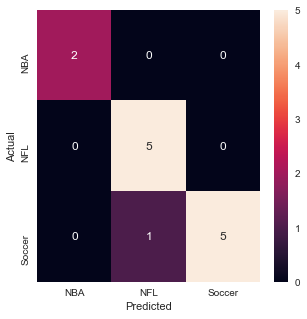

In [31]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

confusion_mat = confusion_matrix(y_test, nb_y_pred)
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(confusion_mat, annot=True, fmt='d',
            xticklabels=svm_clf.classes_, yticklabels=svm_clf.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

## Classification Report

Classification Report produces for each class, metrics on the precision, recall, f1-score and support.

### Jargon

* **precision**: This is the ratio between the number of true positives and the sum of true positives and false positives. This measures the classifier's ability not to label a negative sample as positive. If there are lots of false positives, this ratio is low. Also known as a model's "exactness"
* **recall**: This is the ratio between the number of true positives and the sum of true positives and false negatives. This measures the classifier's ability to find all of the positive samples. If there are lots of false negatives, this ratio is low. Also known as a model's "completeness" or "sensitivity"
* **f1-score**: This is the weighted harmonic mean of the precision and recall, where score is highest at 1 and lowest at 0. 
* **support**: Number of occurrences of each class in `y_true`


In [32]:
from sklearn.metrics import classification_report
print(classification_report(y_test, nb_y_pred))

             precision    recall  f1-score   support

        NBA       1.00      1.00      1.00         2
        NFL       0.83      1.00      0.91         5
     Soccer       1.00      0.83      0.91         6

avg / total       0.94      0.92      0.92        13



## Curves
These curves are used in binary classification, but it can be applied to multi-class using the One v. All strategy. Generally, the Precision-Recall curve is used when we have imbalanced classes, i.e. the positive class is interesting and rare. This is because the precision measurement depends on the prior probability of the positive class. We use the AUC-ROC curve for balanced classes, as the ROC curve remains the same regardless of the baseline prior probability of your positive class. 

### AUC - ROC Curve
[Reference](https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5)

The Area Under the Curve (AUC) - Receiver Operating Characteristics (ROC) Curve tells how much the model is capable of distinguishing between two binary classes. It plots the true positive rate (TPR) vs. the false positive rate (FPR). In the multiclass case, you can plot N ROC curves for N classes using the One v. All methodology. 

![AUC - ROC Curve](https://cdn-images-1.medium.com/max/1600/1*pk05QGzoWhCgRiiFbz-oKQ.png)

$$ TPR = Recall = Sensitivity = \frac{TP}{TP + FN} $$
$$ Specificity = \frac{TN}{TN + FP} $$
$$ FPR = 1 - Specificity = \frac{FP}{TN + FP} $$

Decreasing the threshold means more samples will be labelled positive, so it increases the sensitivity and decreases the specificity. Similarly, increasing the threshold means more samples will be labeled negative, so it decreases the sensitivty and increases the specificity. 

The ideal model has $AUC = 1$, and a random model has $AUC = 0.5$. 

If the distribution of the positive class and negative class's decision functions don't overlap, we can get perfect separability. 

![Ideal Example](https://cdn-images-1.medium.com/max/1600/1*Uu-t4pOotRQFoyrfqEvIEg.png)

When the distributions overlap, this is how we get false negatives and true positives. 

![Overlapping Distributions](https://cdn-images-1.medium.com/max/1600/1*yF8hvKR9eNfqqej2JnVKzg.png)

### Precision - Recall Curve

The Precision-Recall curve plots precision (y-axis) vs. recall (x-axis) for different thresholds. It's similar to the ROC curve in that you want to maximize the area under the curve.

The no-skill line is defined by the number of true positives divided by the total number of true positives and true negatives. 

![Precision-Recall Curve](https://qph.fs.quoracdn.net/main-qimg-ddd56eeeae45bcd95093859b87454e73.webp)

# Most Important Features for Each Class

In [33]:
def show_most_informative_features(vectorizer, clf, n=20):
    # This only works with linear classifiers, so not decision tree classifiers
    feature_names = vectorizer.get_feature_names()
    class_labels = clf.classes_
    top = []
    if len(class_labels) == 2:
        # In the binary case, clf.coef_ is flattened to save space so we have to treat it differently
        coefs_with_words = sorted(zip(clf.coef_[0], feature_names))
        # Gets the most negative values, which corresponds to class 1 (in ascending order)
        top.append(coefs_with_words[:n])
        # Gets the most positive values, which corresponds to class 2 (in descending order)
        top.append(coefs_with_words[:-(n+1):-1])
        for i in [0, 1]:
            print('\n', class_labels[i], '\n')
            for coef, word in top[i]:
                print(coef, word)
    elif len(class_labels) > 2:
        for i, class_label in enumerate(class_labels):
            coefs_with_words = sorted(zip(clf.coef_[i], feature_names))
            # gets the most positive values in descending order
            top.append(coefs_with_words[:-n:-1])
            print('\n', class_labels[i], '\n')
            for coef, word in top[i]:
                print(coef, word)

In [34]:
show_most_informative_features(count_vect, svm_clf)


 NBA 

0.9325517207171532 blazers
0.8860432378875502 durant
0.8071530344387184 korver
0.7949350390240384 harden
0.7502340707148877 warriors
0.656707861824441 nuggets
0.6454379049715003 utah
0.5640480640490383 report cavaliers
0.5640480640490383 cavaliers
0.5624091069403061 kevin durant
0.5624091069403061 kevin
0.4755081712903803 trade
0.4755081712903803 kyle korver
0.4755081712903803 korver trade
0.4462349904155249 warriors hope
0.4462349904155249 rockets warriors
0.4462349904155249 rockets
0.4462349904155249 hope cleaner
0.4462349904155249 hope

 NFL 

0.9545924683390756 week
0.8417765204042968 ravens
0.8296046321527835 giants
0.6051252390105051 raiders
0.5465780278601863 packers
0.4960225160461325 chiefs
0.4425210256884201 orleans
0.4425210256884201 new orleans
0.4425210256884201 new
0.44154015455699 practice
0.4274845372356808 source raiders
0.4274845372356808 raiders crowell
0.4274845372356808 hurt season
0.4274845372356808 hurt
0.4274845372356808 crowell hurt
0.4274845372356808 c

# Building a Pipeline
We can do what we did above with some less code using a Pipeline

A pipeline sequentially applies a list of transforms and a final estimator. 

When you run `.predict` on a pipeline, it applys the transforms to the data and then predicts with the final estimator

In [35]:
from sklearn.pipeline import Pipeline
# Example of a Multinomial Naive Bayes Pipeline
text_clf_pipeline = Pipeline([
    ('vect', CountVectorizer(stop_words=stop_words, ngram_range=(1, 2), min_df=1)),
    ('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB())
])

In [36]:
text_clf_pipeline.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 2), preprocessor=None,
        stop_words=frozenset({...inear_tf=False, use_idf=True)), ('clf', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

In [37]:
# Notice how we don't have to call count_vect.transform if we do a pipeline
text_clf_pipeline.predict(
    ["Raiders signing tight end off Ravens practice squad"])

array(['NFL'], dtype='<U6')

In [38]:
# You can also access the steps within the pipeline using named steps eg
text_clf_pipeline.named_steps['clf']

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

# Finding the Best Model with the Best Parameters

Let's maximize our accuracy by doing cross-validation with repeated KFolds. 

## KFold Cross-Validation
![Kfold](https://static.oschina.net/uploads/img/201609/26155106_OfXx.png)

k-fold cross-validation randomly divides the set of observations into k groups or "folds" of approximately equal size. The first fold is treated as the test set, and the remaining folds are used as training data to create the model. The error is calculated on this test fold. 

This procedure is repeated k times, each time, a different fold is the test set. This results in k estimates of the test error, which are averaged to get the k-fold cross validation estimate. 

The recommended number of folds is generally 5 or 10, as these values have been shown to empirically yeild test error rate estimates that suffer neither from excessively high bias nor from very high variance

In the below method, we use StratifiedKFold, which makes sure each class is represented proportionally to the observation sample in each fold. 

We also repeat the KFold cross-validation test `n_repeats` times and shuffle the observations in the folds to get a more stable view of accuracy

## Optimizing the Text Classifier

In [41]:
import time
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression

def optimize_text_classifier(documents, labels, n_folds=10, n_repeats=10, seed=42, custom_stop_words=ENGLISH_STOP_WORDS, min_df=1):
    """
    Given the documents and labels, we find the best text classifier and if necessary, any
    tuning parameters. 
    This function compares Naive Bayes, Logistic Regression, and LinearSVC. For logistic regression
    and SVC, we also find the optimal regularization parameter C
    The function returns the optimal classifier, a summary of the findings, and the detailed results

    Optional Parameters
    n_folds: Number of folds for KFolds cross validation
    n_repeats: Number of times we repeat KFolds cross validation
    min_df: Minimum number of times a word has to appear in the corpus to be included as a feature
    
    Parameters Not Optimized:
    min_df: We don't vary this parameter, we simply use what was specified in the function call
    Solver for Logistic Regression: We use 'lbfgs' by default
    """
    start = time.time()
    # Tests the range of C values from 2^-7 to 2^7
    c_range = [2**x for x in range(-7, 8)]
    results = {
        "nb": {
            "scores": []
        },
        "logreg": {
            "scores": [],
            "c_list": [],
        },
        "svc": {
            "scores": [],
            "c_list": []
        }
    }
    summary = []
    for n in range(n_repeats):
        for model in results.keys():
            if model == "nb":
                skf = StratifiedKFold(n_splits=n_folds, shuffle=True)
                text_clf = Pipeline([
                    ('vect', CountVectorizer(stop_words=custom_stop_words,
                                             ngram_range=(1, 2), min_df=min_df)),
                    ('tfidf', TfidfTransformer()),
                    ('clf', MultinomialNB())
                ])
                score = np.mean(cross_val_score(
                    text_clf, documents, labels, cv=skf))
                results["nb"]["scores"].append(score)
            else:  # we have to tune for the regularization parameter C
                best_score = 0
                optimal_c = 0
                # It's important that we have a random seed for skf, because we want the same
                # training & test sets for tuning the regularization parameter
                skf = StratifiedKFold(
                    n_splits=n_folds, shuffle=True, random_state=seed)
                seed += 1
                for c in c_range:
                    if model == "logreg":
                        text_clf = Pipeline([
                            ('vect', CountVectorizer(
                                stop_words=custom_stop_words, ngram_range=(1, 2), min_df=min_df)),
                            ('tfidf', TfidfTransformer()),
                            ('clf', LogisticRegression(C=c, solver='lbfgs'))
                        ])
                    elif model == "svc":
                        text_clf = Pipeline([
                            ('vect', CountVectorizer(
                                stop_words=custom_stop_words, ngram_range=(1, 2), min_df=min_df)),
                            ('tfidf', TfidfTransformer()),
                            ('clf', LinearSVC(C=c))
                        ])
                    score = np.mean(cross_val_score(
                        text_clf, documents, labels, cv=skf))
                    if score > best_score:
                        best_score = score
                        optimal_c = c
                results[model]["scores"].append(best_score)
                results[model]["c_list"].append(optimal_c)
    for model in results.keys():
        if model == "nb":
            summary.append((model, np.mean(results[model]["scores"])))
        elif model in ["logreg", "svc"]:
            # get the most frequently occuring optimal c
            mode_c = max(set(results[model]["c_list"]),
                         key=results[model]["c_list"].count)
            summary.append((model, np.mean(results[model]["scores"]), mode_c))
    end = time.time()
    print("Summary of Results:")
    print(summary, '\n')
    # Gets the tuple with the highest avg accuracy
    best = max(summary, key=lambda model_summary: model_summary[1])
    best_avg_score = best[1]
    print("Best Cross Validation Score:", best_avg_score, '\n')
    if best[0] == "nb":
        best_model = MultinomialNB()
    elif best[0] == "logreg":
        best_model = LogisticRegression(C=best[2], solver='lbfgs')
    elif best[0] == "svc":
        best_model = LinearSVC(C=best[2])
    print("Best Model:")
    print(best_model)
    print("\nIt took {} seconds to optimize the model with {} trials".format(
        end-start, n_repeats))
    # Final Pipeline - the only difference is that we use all of the data
    final_pipeline = Pipeline([
        ('vect', CountVectorizer(stop_words=custom_stop_words,
                                 ngram_range=(1, 2), min_df=min_df)),
        ('tfidf', TfidfTransformer()),
        # choose whatever is the best model from the above analysis and use the tuned parameters
        ('clf', best_model)
    ])
    # In the final pipeline, you use all of the data (Training + Test)
    final_pipeline.fit(documents, labels)
    return final_pipeline, summary, results, best_avg_score

In [42]:
final_pipeline, summary, results, best_avg_score = optimize_text_classifier(
    df.Title, df.Category, n_folds=5, seed=56, custom_stop_words=custom_stop_words)

Summary of Results:
[('nb', 0.7291025641025641), ('logreg', 0.7964102564102563, 4), ('svc', 0.7952564102564101, 0.5)] 

Best Cross Validation Score: 0.7964102564102563 

Best Model:
LogisticRegression(C=4, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='lbfgs', tol=0.0001,
          verbose=0, warm_start=False)

It took 16.82603621482849 seconds to optimize the model with 10 trials


In [43]:
final_pipeline.named_steps

{'vect': CountVectorizer(analyzer='word', binary=False, decode_error='strict',
         dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
         lowercase=True, max_df=1.0, max_features=None, min_df=1,
         ngram_range=(1, 2), preprocessor=None, stop_words={'vs', 'v'},
         strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
         tokenizer=None, vocabulary=None),
 'tfidf': TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True),
 'clf': LogisticRegression(C=4, class_weight=None, dual=False, fit_intercept=True,
           intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
           penalty='l2', random_state=None, solver='lbfgs', tol=0.0001,
           verbose=0, warm_start=False)}

### Saving the Classifier

In [45]:
# Save our classifier in a pickle file so we can use it in other environments

import pickle
import sklearn

# It's always a good idea to also include some metadata with your pickle file of a model
# Here's an example of what to put in the metadata dictionary
model_metadata = {
    "owner": {
        "Name": "Marcie Tran",
        "Email": "marcietran@email.com"
    },
    "training_data_source": {  # could be a dict referencing an Azure blob, AWS S3 object etc
    },
    "python_notebook_source": {  # some dict about the source of the python notebook that produced this model
        "type": "local storage",
        "path": r"C:\Users\local\path\to\notebook"
    },
    "dependencies": {
        "sklearn": sklearn.__version__,
        "numpy": np.__version__,
        "pandas": pd.__version__
    },
    # let's you check that the cross val score is about what you'd expect
    "cross_validation_score": best_avg_score
}

# You can also save things directly to S3 instead of a file on a local system
file = open('text_classification_pipeline.pkl', 'wb')
pickle.dump((model_metadata, final_pipeline), file)

### Loading a Pipeline or Model

In [46]:
read_file = open('text_classification_pipeline.pkl', 'rb')
model_metadata, clf_pipeline = pickle.load(read_file)

clf_pipeline.predict(["Raiders signing tight end off Ravens practice squad"])

array(['NFL'], dtype=object)